In [1]:
path = "../input/scene_classification/scene_classification/train/"

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
bs = 64

In [4]:
df = pd.read_csv('../input/scene_classification/scene_classification/train.csv')
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [5]:
tfms = get_transforms(do_flip=False)
data = (ImageItemList.from_csv(path, csv_name='../train.csv') #Where to find the data? -> in path and its subfolders
        .random_split_by_pct()              #How to split in train/valid? -> use the folders
        .label_from_df()            #How to label? -> depending on the folder of the filenames
        .add_test_folder(test_folder = '../test')              #Optionally add a test set (here default name is test)
        .transform(tfms, size=128)       #Data augmentation? -> use tfms with a size of 64
        .databunch())

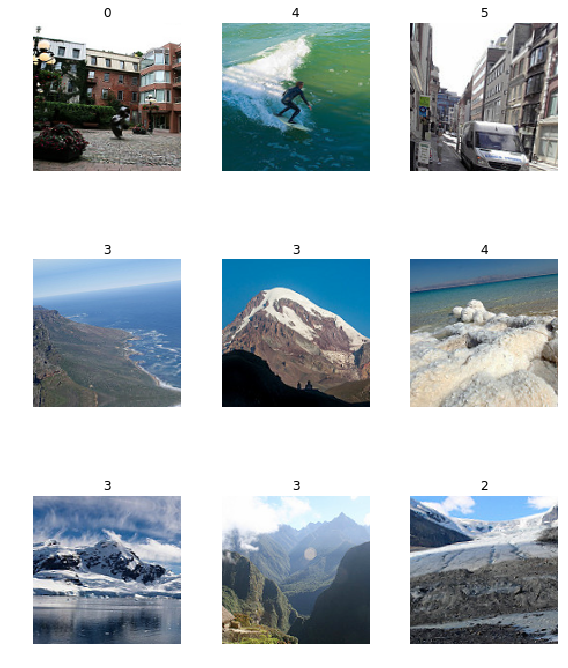

In [6]:
data.show_batch(rows=3, figsize=(8,10))

In [7]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [8]:
learn = create_cnn(data, models.resnet34, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 76258281.35it/s]


In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.516236,0.344183,0.135937,0.864063
2,0.352149,0.276427,0.105989,0.894011
3,0.288245,0.249712,0.095420,0.904580
4,0.265129,0.243140,0.093071,0.906929


In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

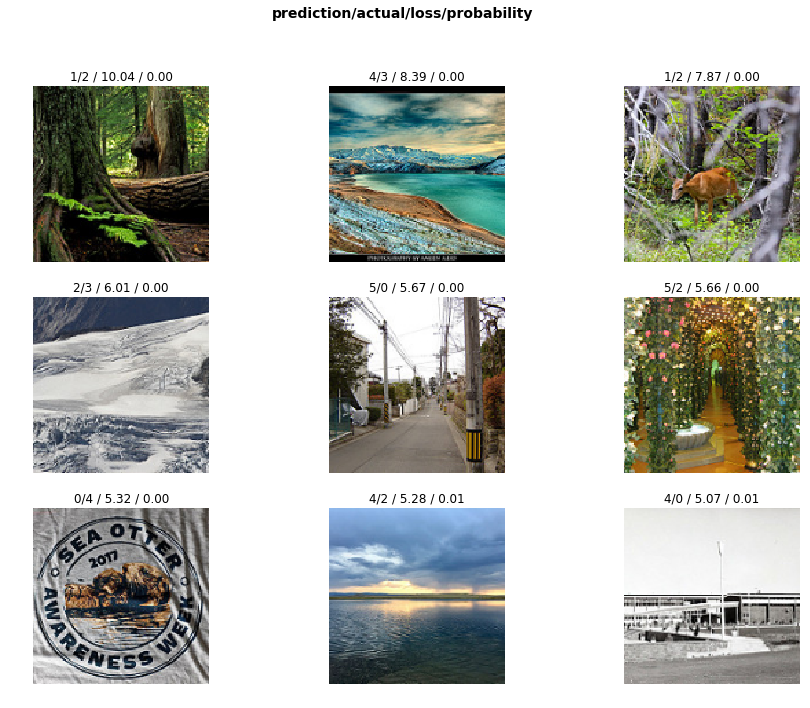

In [11]:
interp.plot_top_losses(9, figsize=(15,11))

In [12]:
interp.most_confused(min_val=2)

[(2, 3, 87),
 (3, 2, 74),
 (0, 5, 36),
 (5, 0, 30),
 (2, 4, 23),
 (4, 3, 12),
 (3, 4, 8),
 (4, 2, 8),
 (1, 3, 5),
 (2, 1, 5),
 (4, 0, 5),
 (2, 0, 4),
 (2, 5, 3)]

In [13]:
learn.save('stage-1')

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


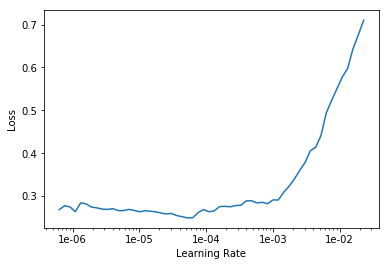

In [16]:
learn.recorder.plot()

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.242487,0.228493,0.090135,0.909865
2,0.227040,0.209574,0.078685,0.921315
3,0.200965,0.206902,0.075455,0.924545
4,0.178180,0.204783,0.073987,0.926013


In [19]:
learn.save('stage-2')

In [20]:
preds,_ = learn.get_preds(ds_type=DatasetType.Test)

In [21]:
labelled_preds = []
for pred in preds:
    labelled_preds.append(int(np.argmax(pred)))
    
# labelled_preds[0:10]
len(labelled_preds)

7301

In [22]:
import os
filenames = os.listdir('../input/scene_classification/scene_classification/test/')

In [23]:
len(filenames) == len(labelled_preds)

True

In [24]:
submission = pd.DataFrame(
    {'image_name': filenames,
     'label': labelled_preds,
    })

In [25]:
submission.to_csv('first_submission.csv')